In [1]:
import gc
import os
import warnings
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from keras import backend as K
warnings.filterwarnings(action='ignore')

K.image_data_format()

Using TensorFlow backend.


'channels_last'

### **File load**

주어진 파일을 확인하고 로드합니다. 

In [2]:
# 혹 다른 데이터 셋 추가(Pretrained Model Weights)로 인해 PATH가 변경된다면 아래 PATH를 수정
DATA_PATH = '.\\data\\'
os.listdir(DATA_PATH)

['.ipynb_checkpoints',
 'class.csv',
 'cropped_test',
 'cropped_train',
 'sample_submission.csv',
 'test',
 'test.csv',
 'train',
 'train.csv']

Data Description에 있는 파일 세부 정보입니다.
* **train.csv** - Train 셋의 이미지 파일명, 바운딩박스 좌표, 차종정보
* **test.csv** - Test 셋의 이미지 파일명, 바운딩박스 좌표, 차종정보
* **submission.csv** - Test셋과 대응되는 제출 파일
* **class.csv** - 데이터 셋의 class 컬럼과 대응되는 차종의 레이블
* **train** - Train 이미지 파일
* **test** - Test 이미지 파일

In [3]:
# 이미지 폴더 경로
TRAIN_IMG_PATH = os.path.join(DATA_PATH, 'cropped_train')
TEST_IMG_PATH = os.path.join(DATA_PATH, 'cropped_test')

# CSV 파일 경로
df_train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
df_test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
df_class = pd.read_csv(os.path.join(DATA_PATH, 'class.csv'))

### **Train_test_split**

In [4]:
from sklearn.model_selection import train_test_split

df_train["class"] = df_train["class"].astype('str')

df_train = df_train[['img_file', 'class']]
df_test = df_test[['img_file']]

its = np.arange(df_train.shape[0])
train_idx, val_idx = train_test_split(its, train_size = 0.8, random_state=42)

X_train = df_train.iloc[train_idx, :]
X_val = df_train.iloc[val_idx, :]

print(train_idx)
print(val_idx)
print()
print(X_train.shape)
print(X_val.shape)
print(df_test.shape)

[4766 4851  533 ... 5390  860 7270]
[1617 9936 2168 ... 1642 9177 4210]

(8012, 2)
(2004, 2)
(6169, 1)


사이킷런의 train_test_split함수를 활용하여 Train 셋을 Train / validation 셋으로 나눴습니다.   
혹시나 해서 말씀드리지만, train_test_split()이라고 해서 test라는 글자에 너무 많은 의미를 부여하지는 않아도 됩니다.  
우리가 원하는 건 특정 array를 원하는 비율로 나누기만 하면 되니까요.

In [12]:
import cv2

def color_change(image):
#     print(type(image))
#     image = cv2.imread(image, cv2.IMREAD_COLOR)
    b, g, r = cv2.split(image)
    rgb_set = ([r, g, b], [r, b, g], [g, r, b], [g, b, r], [b, r, g], [b, g, r])
    converted_img = cv2.merge(rgb_set[np.random.randint(6)])
    return converted_img

In [13]:
# from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import ImageDataGenerator

# Parameter
img_size = (224, 224)
nb_train_samples = len(X_train)
nb_validation_samples = len(X_val)
nb_test_samples = len(df_test)
epochs = 30
batch_size = 40

# Define Generator config
train_datagen = ImageDataGenerator(
    horizontal_flip = True, 
    vertical_flip = False,
    zoom_range=0.10,
    preprocessing_function=color_change)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Make Generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=X_train, 
    directory=TRAIN_IMG_PATH,
    x_col='img_file',
    y_col='class',
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    seed=42
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=X_val, 
    directory=TRAIN_IMG_PATH,
    x_col='img_file',
    y_col='class',
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 8012 images belonging to 196 classes.
Found 2004 images belonging to 196 classes.


In [14]:
cnn_model = ResNet50(include_top=False, input_shape=(224, 224, 3))
# cnn_model.summary()

In [15]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, GlobalAveragePooling2D

# for layer in cnn_model.layers:
#     layer.trainable = False
#     print(layer,layer.trainable)

model = Sequential()
model.add(cnn_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(196, activation='softmax', kernel_initializer='he_normal'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 196)               401604    
Total params: 23,989,316
Trainable params: 23,936,196
Non-trainable params: 53,120
_________________________________________________________________


Pretrained Model을 사용할 때 한가지 주의할 점이 있습니다. Pretrained 모델은 경우에 따라 다양하게 사용될 수 있기 때문에 Model output부분을 잘라버린 채 로드 되는 경우가 있습니다.(include_top=False) 이 경우에는 직접 output을 만들어야 되겠죠? 우리는 196개의 class를 분류하기 때문에 위와 같이 만들었습니다.

참고)  
케라스에는 모델을 생성하는 방법이 2가지가 있습니다. 하나는 위처럼 Sequential을 사용하는 것이고 하나는 Model을 사용하는 방법입니다. 2가지 모두 많이 사용하니 Model도 한번 사용해보세요.

### **Model Compile**
이제 Model을 만들었으니 어떻게 학습할 지 정해야 합니다. 어떤 방법으로, 어떤 속도로, 어떤 지표를 기준으로 등등 정할 수 있고 필요시에는 각각의 함수를 직접 구현해볼 수도 있습니다. 하지만, 보통은 기본으로 주어지는 것들을 사용합니다.

In [16]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

### **Model Training**
이제 진짜로 학습을 해봅시다. 학습에는 시간이 조금 걸리니 커피라도 한 잔 하시는게 어떨까요?

In [10]:
def get_steps(num_samples, batch_size):
    if (num_samples % batch_size) > 0 :
        return (num_samples // batch_size) + 1
    else:
        return num_samples // batch_size

In [ ]:
%%time
from keras.callbacks import ModelCheckpoint, EarlyStopping

# filepath = "resnet50_model_ep{epoch:02d}_{acc:.4f}_{loss:.4f}.h5"
# ckpt = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True)
# es = EarlyStopping(monitor='acc', min_delta=0, patience=3, verbose=1, mode='auto')

filepath = "resnet50_model_ep{epoch:02d}_{val_acc:.4f}_{val_loss:.4f}.h5"
ckpt = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=1, mode='auto')

callback_list = [ckpt, es]

history = model.fit_generator(
    train_generator,
    steps_per_epoch=get_steps(nb_train_samples, batch_size),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=get_steps(nb_validation_samples, batch_size),
    callbacks=callback_list,
#     use_multiprocessing=True
)
gc.collect()

Epoch 1/30
201/201 [==============================] - 148s 735ms/step - loss: 4.7086 - acc: 0.0522 - val_loss: 6.9977 - val_acc: 0.0230

Epoch 00001: val_acc improved from -inf to 0.02295, saving model to resnet50_model_ep01_0.0230_6.9977.h5
Epoch 2/30
201/201 [==============================] - 131s 652ms/step - loss: 2.6620 - acc: 0.3319 - val_loss: 5.6903 - val_acc: 0.0813

Epoch 00002: val_acc improved from 0.02295 to 0.08134, saving model to resnet50_model_ep02_0.0813_5.6903.h5
Epoch 3/30
201/201 [==============================] - 138s 686ms/step - loss: 1.4235 - acc: 0.6068 - val_loss: 6.2336 - val_acc: 0.0868

Epoch 00003: val_acc improved from 0.08134 to 0.08683, saving model to resnet50_model_ep03_0.0868_6.2336.h5
Epoch 4/30
160/201 [======================>.......] - ETA: 25s - loss: 0.9034 - acc: 0.7397

In [12]:
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping

model = load_model('.\\resnet50_model_ep18_0.7315_1.1904.h5')

val_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
#    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
#    fill_mode='nearest',
    preprocessing_function=preprocess_input)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=X_val, 
    directory=TRAIN_IMG_PATH,
    x_col='img_file',
    y_col='class',
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

filepath = "resnet50_final_ep{epoch:02d}_{acc:.4f}_{loss:.4f}.h5"
ckpt = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True)
# es = EarlyStopping(monitor='acc', min_delta=0, patience=5, verbose=1, mode='auto')

# callbackList = [ckpt, es]
callbackList = [ckpt]

history = model.fit_generator(
    validation_generator,
    steps_per_epoch=get_steps(nb_validation_samples, batch_size),
    epochs=3,
    callbacks=callbackList
)
gc.collect()

Found 2004 images belonging to 196 classes.
Epoch 1/3
63/63 [==============================] - 38s 598ms/step - loss: 1.1305 - acc: 0.6897

Epoch 00001: acc improved from -inf to 0.68962, saving model to resnet50_final_ep01_0.6896_1.1301.h5
Epoch 2/3
63/63 [==============================] - 30s 482ms/step - loss: 0.5235 - acc: 0.8396

Epoch 00002: acc improved from 0.68962 to 0.83982, saving model to resnet50_final_ep02_0.8398_0.5226.h5
Epoch 3/3
63/63 [==============================] - 35s 548ms/step - loss: 0.2814 - acc: 0.9109

Epoch 00003: acc improved from 0.83982 to 0.91068, saving model to resnet50_final_ep03_0.9107_0.2822.h5


13

### **Training History Visualization**
학습된 결과를 plot으로 그려볼 수 있습니다. 모델 학습 로그를 통해서 확인할 수도 있지만, 전반적인 학습 형태를 한눈에 파악하기에는 그래프만 한 것이 없습니다.

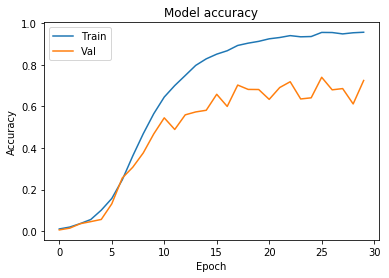

In [18]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

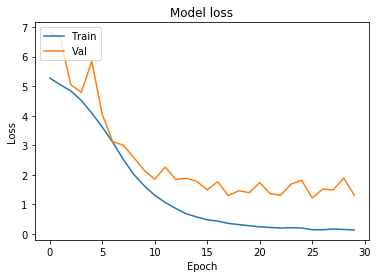

In [35]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# <a id='5'><strong>Predict & Make submission</strong></a>  
겨우 모델 학습이 끝났군요! 하지만, 아직 끝나지 않았습니다. 모델이 테스트 데이터에도 잘 적용되는지 predict를 해보고 제출물을 만들어야 합니다.

### **Model Predict**

In [15]:
%%time
from keras.models import load_model

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=TEST_IMG_PATH,
    x_col='img_file',
    y_col=None,
    target_size=img_size,
    color_mode='rgb',
    class_mode=None,
    batch_size=batch_size,
    shuffle=False)

model = load_model('.\\resnet50_final_ep02_0.8398_0.5226.h5')

test_generator.reset()

prediction = model.predict_generator(
    generator = test_generator,
    steps = get_steps(nb_test_samples, batch_size),
    verbose=1
)

Found 6169 images.
193/193 [==============================] - 52s 271ms/step
Wall time: 1min 55s


Predict 또한 제너레이터를 사용합니다. 제너레이터는 메모리가 부족한 우리들에게 꼭 필요한 기능입니다!

### **Make submission**

Inference가 끝난 결과를 이제 sample_submission 파일에 매핑해야 합니다. sample_submission 파일을 불러온 후 예측한 결과를 매핑합니다.

중요)  
케라스 제너레이터를 사용하는 경우에는 타겟(클래스)의 카테고리컬 매핑이 제너레이터 임의로 결정됩니다. 따라서 제너레이터가 가지고 있는 class index 딕셔너리를 불러와 새롭게 매핑해주어야 합니다.

In [17]:
predicted_class_indices=np.argmax(prediction, axis=1)

# Generator class dictionary mapping
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

submission = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission.csv'))
submission["class"] = predictions
submission.to_csv("submission.csv", index=False)
submission.head()

,img_file,class
0,test_00001.jpg,124
1,test_00002.jpg,98
2,test_00003.jpg,157
3,test_00004.jpg,184
4,test_00005.jpg,17


드디어 완료 되었습니다. 하지만, 여기서 끝이 아니죠!   
첫 제출을 성공하셨다면 이제는 모델 성능을 어떻게하면 더 올릴 수 있을지 연구할 때입니다.   
끝나는 시간까지 계속 킵고잉해서 좋은 성능을 낼 때까지 달립시다. 모두 화이팅!

#### **Reference:**
https://medium.com/@vijayabhaskar96/tutorial-on-keras-flow-from-dataframe-1fd4493d237c  
https://keras.io/  
http://www.arxiv.org/abs/1512.03385  
https://pillow.readthedocs.io/en/stable/  
https://www.kaggle.com/guglielmocamporese/macro-f1-score-keras